In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/MACHINE LEARNING/Praktikum 3/Data/stunting_wasting_dataset.csv')

# Cetak header data (5 baris data) dari file
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [ ]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [ ]:
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [ ]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [ ]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [ ]:
# 1, Mapping kolom stunting -> biner
map_stunt = {'Stunted': 1, 'Normal': 0, 'Tall':0, 'Severely Stunted': 1}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype(int)

# 2. Mapping kolom jenis kelamin biner
# laki laki =1 perempuan 0

df['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)
print("Distrbusi Stunting_bin\n", df['Stunting_bin'].value_counts())
print("\n Distribusi JK_bin:\n", df['JK_bin'].value_counts())

Distrbusi Stunting_bin
 Stunting_bin
0    78021
1    21979
Name: count, dtype: int64

 Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.038630,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.283855,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.021090,0.045797
Stunting_bin,0.038630,-0.283855,0.021090,1.000000,-0.005981
JK_bin,0.004046,0.073505,0.045797,-0.005981,1.000000


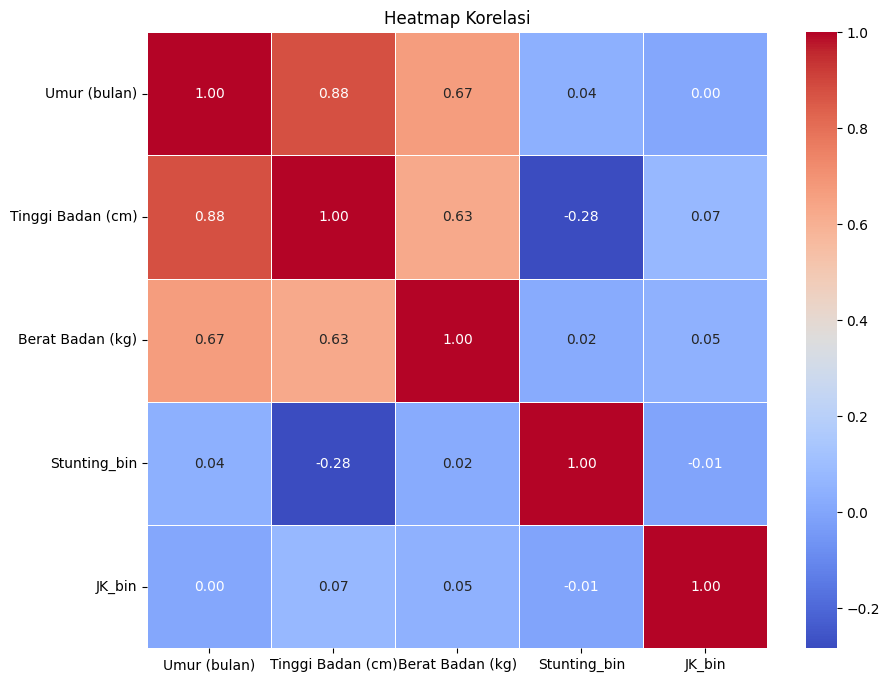

In [ ]:
# Visualisasi heatmap
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi', fontsize=12)
plt.show()

In [ ]:
# Fitur numerik dan gender
feature_num =['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# Gabungan & Drop mising
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_use = df[use_cols].dropna().copy()

x = df_use[feature_num + feature_bin]
y = df_use['Stunting_bin']

print("Shape X:", x.shape)
print("Shape Y:", y.shape)

Shape X: (100000, 4)
Shape Y: (100000,)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("Data latih:", x_train.shape)
print("Data uji:", x_test.shape)

Data latih: (80000, 4)
Data uji: (20000, 4)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#scale hanya fitur numerik, gender langsung passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter = 1000,
    solver='lbfgs',
    class_weight = 'balanced',
    random_state = 42
)

clf = Pipeline(steps=[('preprocess', preprocess), ('model', model)])

clf.fit(x_train, y_train)
print("model logistis regresion berhasil dilatih")

model logistis regresion berhasil dilatih


In [ ]:
# Prediksi & probabilitas
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:,1]

#hitung numerik
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print(f"Akurasi:, {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:, {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall:, {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score:, {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"AUC:, {roc_auc_score(y_test, y_prob):.4f}")

Akurasi:, 0.9055
Precision:, 0.7152
Recall:, 0.9472
F1 Score:, 0.8150
AUC:, 0.9656


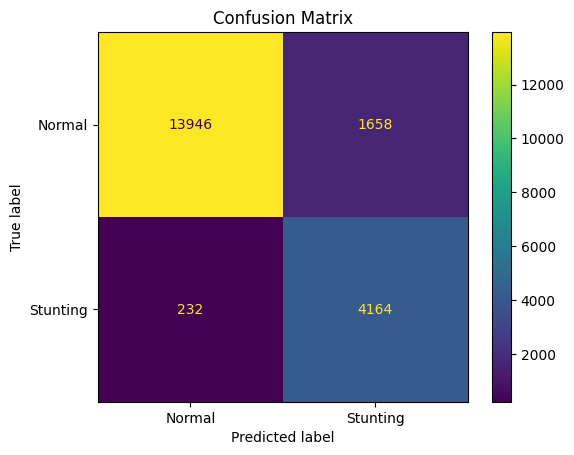

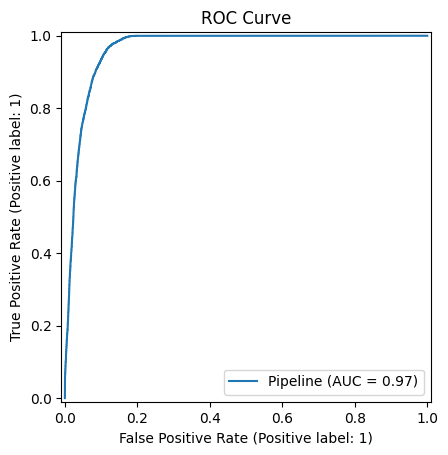

In [ ]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Normal','Stunting']).plot(values_format='d')
plt.title('Confusion Matrix')
plt.show()

#ROC Curve
RocCurveDisplay.from_estimator(clf, x_test, y_test)
plt.title('ROC Curve')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['tidak stunting(0)', 'Stunting(1)']))

                   precision    recall  f1-score   support

tidak stunting(0)       0.98      0.89      0.94     15604
      Stunting(1)       0.72      0.95      0.82      4396

         accuracy                           0.91     20000
        macro avg       0.85      0.92      0.88     20000
     weighted avg       0.92      0.91      0.91     20000



In [ ]:
from sklearn.model_selection import cross_val_score

# Lakukan cross validation(cv=)